# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

In [83]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import least_squares

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    assert L0.shape == v.shape
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    lsq = least_squares(diffFunAnon, np.full_like(L0, Rtot/2.0), jac_sparsity=np.eye(L0.size),
                        max_nfev=1000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        bounds=(np.full_like(L0, -np.finfo(float).eps), np.full_like(L0, Rtot)))
    if lsq['cost'] > 1.0E-8:
        print(lsq)
        raise RuntimeError("Failure in solving for Req.")
        
    Req = lsq.x
    Lbound = np.zeros(Req.size)
    Rmulti = np.zeros(Req.size)
    Rbnd = np.zeros(Req.size)
    
    for ii, Reqq in enumerate(Req):
        # Calculate vieq (amount of oligomer in valency) from equation 1
        vieq = L0[ii]*Reqq*binom(v[ii], np.arange(1, v[ii] + 1))*np.power(Kx*Reqq, np.arange(v[ii]))/Kd

        # Calculate L (total # of oligomer bound per cell), according to equation 7
        Lbound[ii] = np.sum(vieq)

        # Calculate Rmulti (# of cross-linked receptors) from equation 5
        Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=np.float))

        # Calculate Rbound
        Rbnd[ii] = Rmulti[ii] + vieq[0]

    return (Lbound, Rbnd, Rmulti)

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

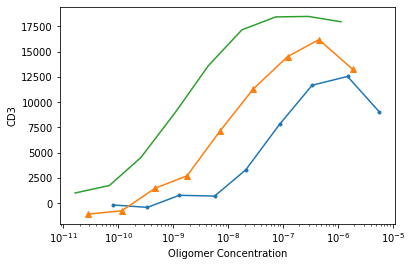

In [84]:
# Answer
import math
plt.xscale('log')
plt.plot(Xs[Vs==2], Ys[Vs==2], label='Dimer', marker = '.')
plt.plot(Xs[Vs==3], Ys[Vs==3], label = 'Trimer', marker = '^')
plt.plot(Xs[Vs==4], Ys[Vs==4], label = 'Tetramer', marker = ' ')
plt.xlabel('Oligomer Concentration')
plt.ylabel('CD3')
plt.show()

At equilibrium, valency increases when Kx > Kd until it hits the saturation oligomer concentration

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

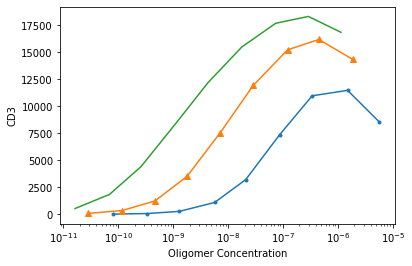

In [85]:
# Answer
def scaleStoneMod(Rtot, Kd, v, Kx, L0, param):
    Lbound, Rbnd, Rmulti = StoneMod(Rtot, Kd, v, Kx, L0)
    scaled_Lbound = Lbound * param
    scaled_Rbnd = Rbnd * param
    scaled_Rmulti = Rmulti * param
    return (scaled_Lbound, scaled_Rbnd, scaled_Rmulti)
    
a = scaleStoneMod(24000, 1.70e-6, Vs, 3.15e-4, Xs, 1)

plt.xscale('log')
plt.plot(Xs[Vs==2],a[2][Vs==2], label='Dimer', marker = '.')
plt.plot(Xs[Vs==3],a[2][Vs==3], label='Trimer', marker = '^')
plt.plot(Xs[Vs==4],a[2][Vs==4], label='Tetramer', marker = ' ')
plt.xlabel('Oligomer Concentration')
plt.ylabel('CD3')
plt.show()




#### (2) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [86]:
# Answer
import scipy as scipy

def residual(pMat, Rtot, L0, v, Ys):
    Lbound, Rbnd, Rmulti = scaleStoneMod(Rtot, pMat[0], v, pMat[1], L0, pMat[2])
    error = Rmulti - Ys
    return error

optimized = scipy.optimize.least_squares(residual, [1.0e-6,1.0e-4,1.0], args=(24000, Xs, Vs, Ys))
fitparams = optimized.x
cost = optimized.cost
print("Our least squares solution for Kd is",fitparams[0])
print("Our least squares solution for Kx is",fitparams[1])
print("Our least squares solution for scale is",fitparams[2])
print("Our least squares total cost is",cost)



Our least squares solution for Kd is 1.7028606717011167e-06
Our least squares solution for Kx is 0.0003147313167778577
Our least squares solution for scale is 1.028150204471356
Our least squares total cost is 6858021.330489076


#### (3) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

Text(0, 0.5, 'Estimated')

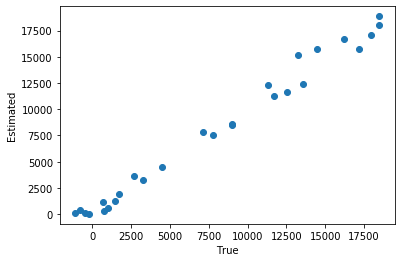

In [8]:
# Answer use in a for array. separate testing and training. 

from sklearn.model_selection import LeaveOneOut
leave = LeaveOneOut()
estimates = np.zeros(Ys.size)

for train_index, test_index in leave.split(Xs):
    train_Xs = Xs[train_index]
    train_Vs = Vs[train_index]
    train_Ys = Ys[train_index]
    
    trained_model = scipy.optimize.least_squares(residual,[1.0e-6, 1.0e-4,1.0], args = (24000, train_Xs, train_Vs, train_Ys))
    trainedparams = trained_model.x #give back the solution it found of the least squares
    estimates[test_index] = scaleStoneMod(24000, trainedparams[0], Vs[test_index], trainedparams[1], Xs[test_index], trainedparams[2])[2]
        
plt.scatter(Ys, estimates)
plt.xlabel("True")
plt.ylabel("Estimated")


Yes, the model predicts the data

#### (4) Using bootstrap estimation, plot the confidence interval of the model along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

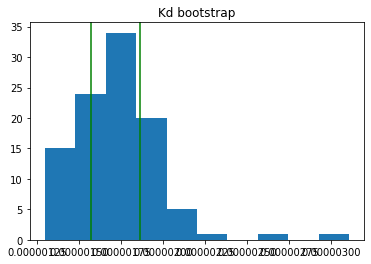

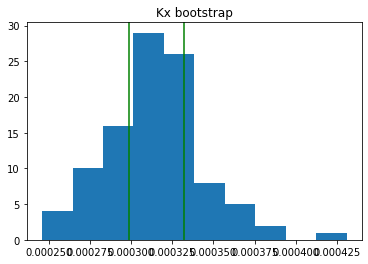

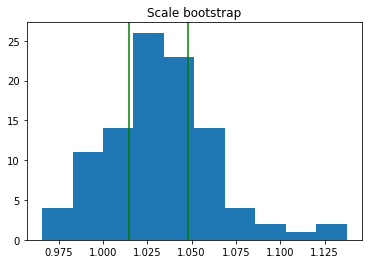

In [114]:
# Answer. do it 100 times. FInal: look 100 model predictions that are slightly different

from sklearn.utils import resample

bootstrapNum = 101
bootKd, bootKx, bootscale = np.zeros([101]), np.zeros([101]), np.zeros([101])

for i in range(0,bootstrapNum):
    bootstrapInd = resample(range(Xs.shape[0])) #randomly select a bunch of indices
    bootstrap_model = least_squares(residual, [1.0e-6,1.0e-4,1.0], args=(24000,Xs[bootstrapInd],Vs[bootstrapInd],Ys[bootstrapInd]))
    bootKd[i], bootKx[i], bootscale[i] = bootstrap_model.x[0], bootstrap_model.x[1], bootstrap_model.x[2]

plt.hist(bootKd)
plt.title("Kd bootstrap")
d25 = np.percentile(bootKd,25)
d75 = np.percentile(bootKd,75)
plt.axvline(x=d25, color = 'g')
plt.axvline(x=d75, color = 'g')
plt.figure()

x25 = np.percentile(bootKx,25)
x75 = np.percentile(bootKx,75)
plt.title("Kx bootstrap")
plt.hist(bootKx)
plt.axvline(x=x25, color ='g')
plt.axvline(x=x75, color = 'g')

plt.figure()
plt.title("Scale bootstrap")
plt.hist(bootscale)
s25 = np.percentile(bootscale,25)
s75 = np.percentile(bootscale,75)
plt.axvline(x=s25, color = 'g')
plt.axvline(x=s75, color = 'g')

#### (5) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

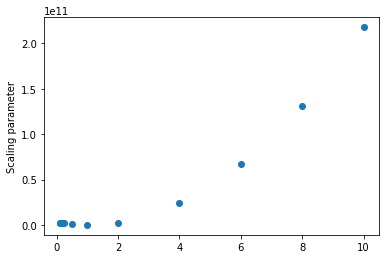

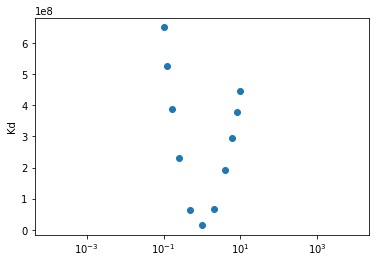

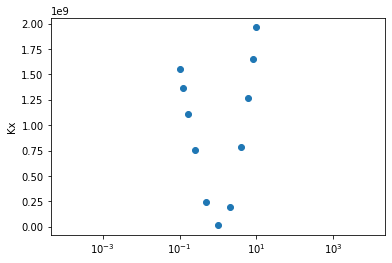

In [75]:
# Answer
#StoneMod(Rtot, Kd, v, Kx, L0)

# a = scaleStoneMod(24000, 1.70e-6, Vs, 3.15e-4, Xs, 1)
# b = scaleStoneMod(24000, 1.70e-6, Vs, 3.15e-4, Xs, 10)
import math
#1/10 1/8 1/6 1/4 1/2 1 2 4 6 8 10

num = [0.1,0.125,1/6,0.25,0.5,1,2,4,6,8,10]
x = np.arange(0,11)
SSEscale = np.zeros(11)
Kdscale = np.zeros(11)
Kxscale = np.zeros(11)

for j in x:
    a = residual([1.7e-6,3.15e-4,num[j]], 24000, Xs, Vs, Ys)
    SSEscale[j] = sum(a**2)

for i in x:
    a = residual([(1.7e-6)*num[i], 3.15e-4, 1.0], 24000, Xs, Vs, Ys)
    Kdscale[i] = sum(a**2)

for h in x:
    a = residual([1.7e-6, (3.15e-4)*num[h], 1.0], 24000, Xs, Vs, Ys)
    Kxscale[h] = sum(a**2)
    
plt.scatter(num,SSEscale)
plt.ylabel('Scaling parameter')
plt.figure()

plt.xscale('log')
plt.scatter(num,Kdscale)
plt.ylabel('Kd')
plt.figure()

plt.xscale('log')
plt.scatter(num,Kxscale)
plt.ylabel('Kx')
plt.show()

Scale influence the fit most, because scale has the greatest value compared to the other parameters. Whereas Kd influence the fit least.

#### (6) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

The global analysis will return a less specified prediction. Since the local sensitivity analysis ignores codependency between parameters, it does not take into account the change of the other parameters when a parameter is shifted. Whereas in global analysis, the other parameters will adjust when one of the parameter is changed. That is why it becomes less specified.

#### (7) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: Probably the easiest way to do this is mess with the bounds of the least squares solver.

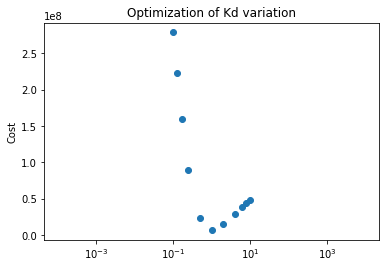

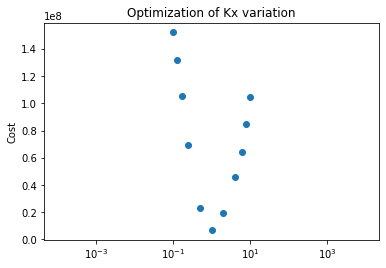

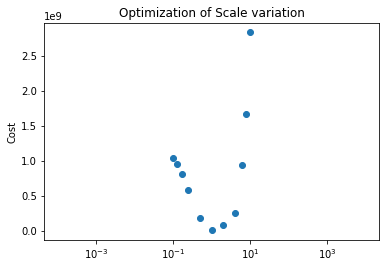

In [98]:
# Answer. Lower PE than number 5. but pretty much should give you back the same thing

num = [0.1,0.125,1/6,0.25,0.5,1,2,4,6,8,10]
Kdd = np.zeros(11)
Kxx = np.zeros(11)
Scalee = np.zeros(11)

for i in np.arange(0,11):
    a = least_squares(residual,[(1.7e-6)*num[i], (3.15e-4), 1.0], bounds = ([(1.7e-6)*num[i]*0.99,3.15e-5,0.1],[(1.7e-6)*num[i]*1.01,3.15e-3,10]), args=(24000, Xs, Vs, Ys))
    fitted = a.x
    Kdd[i] = a.cost
    
    b = least_squares(residual,[(1.7e-6), (3.15e-4)*num[i], 1.0], bounds = ([1.7e-7,3.15e-4*num[i]*0.99,0.1],[1.7e-5,3.15e-4*num[i]*1.01,10]), args=(24000, Xs, Vs, Ys))
    Kxx[i] = b.cost

    c = least_squares(residual,[(1.7e-6), (3.15e-4), 1.0*num[i]], bounds = ([1.7e-7,3.15e-5,0.99*num[i]],[1.7e-5,3.15e-3,1.01*num[i]]), args=(24000, Xs, Vs, Ys))
    Scalee[i] = c.cost
    
plt.xscale('log')    
plt.scatter(num,Kdd)
plt.title("Optimization of Kd variation")
plt.ylabel('Cost')
plt.figure()

plt.xscale('log')
plt.scatter(num,Kxx)
plt.title("Optimization of Kx variation")
plt.ylabel('Cost')
plt.figure()

plt.xscale('log')
plt.scatter(num,Scalee)
plt.title("Optimization of Scale variation")
plt.ylabel('Cost')
plt.show()


The prediction is right because the U shape is wider, corresponding to a lower cost. When the Kd increases, the other parameters will adjust itself in order to minimize the cost.

#### (8) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? *In general*, which sort of quantities do you think will be most exactly predicted?

Confidence value for Lbound : 546.5356728995885
Confidence value for Rbound : 604.9888613503535
Confidence value for Rmulti : 462.99065257794064


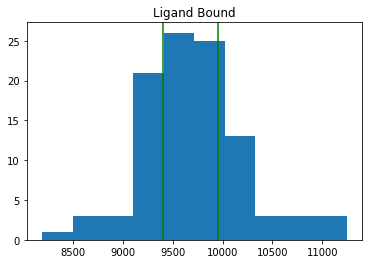

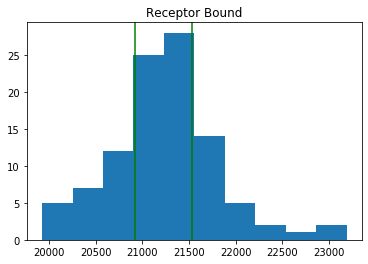

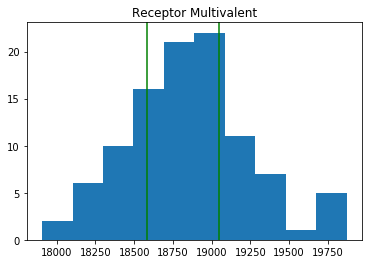

In [116]:
# Answer. find histogram
eLbound = np.zeros(101)
eRbnd = np.zeros(101)
eRmulti = np.zeros(101)

for i in range(0,101):
    eLbound[i], eRbnd[i], eRmulti[i] = scaleStoneMod(24000, bootKd[i], Vs[25:26], bootKx[i], Xs[25:26], bootscale[i])

plt.title("Ligand Bound")
plt.hist(eLbound)
lb25 = np.percentile(eLbound,25)
lb75 = np.percentile(eLbound,75)
plt.axvline(x=lb25, color = 'g')
plt.axvline(x=lb75, color = 'g')

print("Confidence value for Lbound :",lb75-lb25)

plt.figure()
plt.title("Receptor Bound")
plt.hist(eRbnd)
rb25 = np.percentile(eRbnd,25)
rb75 = np.percentile(eRbnd,75)
plt.axvline(x=rb25, color = 'g')
plt.axvline(x=rb75, color = 'g')

print("Confidence value for Rbound :", rb75 - rb25)

plt.figure()
plt.title("Receptor Multivalent")
plt.hist(eRmulti)
rm25 = np.percentile(eRmulti,25)
rm75 = np.percentile(eRmulti,75)
plt.axvline(x=rm25, color = 'g')
plt.axvline(x=rm75, color = 'g')

print("Confidence value for Rmulti :", rm75 - rm25)

Those are less specified than Rmulti. In general, the variable that has the least confidence will be the most exactly predicted.

#### (9) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. How might more measurements of different types be better than more measurements of the same type?

To fit the data along with the multimerized receptor measurements, I won't split the Rbnd and Rmulti beforehands, because I want the model to be able to know which one is which.
When you measure different types of data, the model will be exposed to more variation of data, allowing it to be a better model.